# Оценка эффективности торговых точек

Задачей работы является анализ сетевых магазинов строительных материалов. На основе датасета, содержащего данные о покупках за декабрь 2016 - февраль 2017 года, требуется сравнить эффективность отдельных торговых точек.

### Материалы
- [Дашборд](https://public.tableau.com/profile/vladimir.tauber#!/vizhome/retail_analysis/Dashboard1)

## Содержание <a id='contents'></a>
1. [План решения задачи](#decompose)
2. [Загрузка и предобработка данных](#load)
3. [Исследовательский анализ данных](#eda)
4. [Расчет основных метрик и  сравнение магазинов](#metrics)
5. [Проведение статистических тестов](#test)
6. [Классификация небольших магазинов](#clusters)
7. [Общий вывод](#conclusion)

## 1. План решения задачи <a id='decompose'></a>

<details>
  <summary>Click to expand</summary>
  
#### 1. Загрузка и преобработка данных
- Нужно ли изменить типы данных, переименовать столбцы?
- Есть ли в данных пропуски, как они могли возникнуть и стоит ли их заполнять?
- Есть ли в данных дубликаты?
- Что могут обозначать нереалистичные значения - нулевые и отрицательные цена и количество? Могут ли это быть подарки, возвраты и т.д.?
- Необходимо расчитать стоимость каждой позиции для дальнейшего анализа.
- Каковы максимальные, минимальные и средние/медианные размеры одной позиции? Есть ли среди них выбросы?

#### 2. Исследовательский анализ данных
- Как данные распределены во времени? Есть ли зависимость продаж от дня недели/времени суток? 
- Сколько покупают отдельные пользователи? Есть ли у нас возвращающиеся пользователи (хотя, понятно, период достаточно короткий)? Насколько часто они ходят в один и тот же магазин, есть ли здесь какая-то связь с программой лояльности?

#### 3. Расчет основных метрик
- Как продажи распределены по магазинам? (скорее всего, самый большой магазин окажется абсолютным лидером, но, возможно, удастастся сделать какие-то наблюдения относительно более мелких магазинов)?
- Каковы средние размеры чека в нашей сети? Каков средний чек и средняя глубина чека в каждом магазине?
- Можем ли мы рассчитать долю возврата в отдельных магазинах?  
- Какая доля выручки создается пользователями программы лояльности?
    
#### 4. Анализ отдельных групп магазинов
- Можем ли мы выделить отдельные группы магазинов?  
- Можно ли для решения этой задачи применить кластеризацию?      

#### 5. Проведение статистических тестов
Конкретные формулировки гипотез зависят от результатов предыдущих этапов анализа. Поскольку у нас много магазинов и не для всех достаточно данных, проводить множественные тесты для всех них по отдельности нецелесообразно. Более обоснованным представляется сравнение показателей в самом большом магазине и всех остальных в совокупности. Возможно, "все остальные" также не составляют монолитной группы и, если получится выделить в них 2-3 категории, то показатели для каждой из них можно будет сравнить между собой и с самым большим магазином. Пока что, предполагая деление магазинов на "самый большой" и "все остальные", можно выдвинуть следующие предварительные гипотезы (это не формулировки нулевых гипотез в статистическом смысле, а предположения, которые можно проверить):
- Величина среднего чека в крупном магазине больше, чем во всех остальных.

#### 6. Общий вывод, подготовка презентации и дашборда


---

[Наверх](#contents)
</details>

---

## 2. Загрузка и предобработка данных <a id='load'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
from IPython.display import display
from collections import Counter
from scipy import stats as st
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage 

filterwarnings('ignore')
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14

In [2]:
retail_data = pd.read_csv(r'retail_dataset.csv')
print(retail_data.info())
print(retail_data.describe())
retail_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchaseid       105335 non-null  object 
 1   item_ID          105335 non-null  object 
 2   Quantity         105335 non-null  int64  
 3   purchasedate     105335 non-null  object 
 4   CustomerID       69125 non-null   float64
 5   ShopID           105335 non-null  object 
 6   loyalty_program  105335 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB
None
            Quantity    CustomerID  loyalty_program
count  105335.000000  69125.000000    105335.000000
mean        7.821218  21019.302047         0.226345
std       327.946695   1765.444679         0.418467
min    -74216.000000  18025.000000         0.000000
25%         0.000000  19544.000000         0.000000
50%         2.000000  20990.000000         0.000000
75%         7.000000  22659.000000  

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0


In [3]:
f'Число полных дубликатов: {retail_data.duplicated().sum()}'

'Число полных дубликатов: 1033'

Первые наблюдения:
1. В таблице очень много пропусков в столбце `CustomerID` (примерно треть).
2. В столбце `Quantity` очень много нулей (больше 25%, т.к. первый квартиль равен нулю), кроме того, есть отрицательные значения, возможно, возвраты.
3. В таблице чуть меньше 1% дубликатов.
4. Нужно заменить типы данных: `purchasedate` на `datetime`, `CustomerID` на `str` (желательно, но сначала нужно обработать дубликаты), `loyalty_program` на `int`.
5. Нужно создать дополнительные признаки - дату и время покупки, а также общую стоимость каждой позиции (на основе данных двух таблиц).

In [4]:
# переименуем столбцы для удобства
retail_data.columns = ['purchase_id', 'item_id', 'quantity', 'purchase_dt', 'customer_id', 'shop_id', 'is_loyal']

In [5]:
product_codes = pd.read_csv(r'product_codes.csv')
print(product_codes.info())
print(product_codes.describe())
product_codes.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   productID      9969 non-null   object 
 1   price_per_one  9969 non-null   float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB
None
       price_per_one
count    9969.000000
mean       19.503697
std       330.880754
min         0.000000
25%         1.250000
50%         2.550000
75%         5.510000
max     16888.020000


,productID,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39


In [6]:
print(f'''
Число полных дубликатов: {product_codes.duplicated().sum()}
Число дубликатов по ID товара: {product_codes.duplicated(subset=['productID']).sum()}
''')


Число полных дубликатов: 0
Число дубликатов по ID товара: 6810



Первые наблюдения:
1. Пропусков и полных дубликатов нет, типы данных. 
2. Многие товары имеют больше одной цены.
3. Нужно сравнить ID продуктов в двух таблицах, прежде чем их объединять.

In [7]:
# переименуем столбцы для удобства
product_codes.columns = ['product_id', 'price_per_unit']

### Обработка дубликатов

In [8]:
print(f'''
Число полных дубликатов: {retail_data.duplicated().sum()}
Доля полных дубликатов: {retail_data.duplicated().sum() / len(retail_data):.2%}
''')


Число полных дубликатов: 1033
Доля полных дубликатов: 0.98%



Как уже отмечалось, в нашем основном датафрейме 1033 дубликата, их доля составляет меньше 1%, как представляется, они возникли в результате технических проблем, так что их можно безболезненно удалить.

In [9]:
retail_data.drop_duplicates(inplace=True)

Сложнее ситуация с дубликатами в таблице цен. По-видимому, в течение интересующего нас периода цены на товары менялись. Если это так, то мы ожидаем, что в таблице есть некоторое количество пар/троек/четверок предметов, значения цен для которых отличаются. Проверим, как выглядят дубликаты в таблице цен с этой точки зрения.

In [10]:
prices = product_codes.groupby('product_id', as_index=False).agg(['count', 'min', 'max', 'mean', 'median'])
prices.columns = ['count', 'min', 'max', 'mean', 'median']

prices.sort_values('count', ascending=False).head(20)

,count,min,max,mean,median
product_id,,,,,
DOT,174,2.51,950.99,278.734425,198.190
M,59,0.19,1715.85,253.765932,12.750
S,29,2.80,128.56,30.125172,12.950
POST,15,0.00,40.00,16.638000,12.990
D,13,5.76,281.00,77.072308,42.500
79321,11,0.00,12.46,7.013636,5.750
47566,10,3.75,10.79,6.846000,6.625
84406B,10,0.00,8.29,4.253000,3.625
AMAZONFEE,9,1.00,16888.02,9268.762222,6706.710


In [11]:
prices['count'].describe()

count    3159.000000
mean        3.155745
std         3.635523
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max       174.000000
Name: count, dtype: float64

In [12]:
retail_data[retail_data['item_id'] == 'DOT']['purchase_id'].count()

175

In [13]:
retail_data[retail_data['item_id'] == 'POST']['purchase_id'].count()

217

In [14]:
retail_data[retail_data['item_id'] == '22834']['purchase_id'].count()

231

In [15]:
retail_data[retail_data['item_id'].str.contains('22834')]['purchase_id'].count()

231

Итак, мы видим, что у нас есть дубликаты нескольких видов. Товары `POST`, `AMAZONFEE` и им подобные - это тарифы, комиссии и т.д., соответственно, они имеют много значений, причем назначаются, очевидно, по-разному: напримери, `DOT` имеет 174 варианта на 175 упоминаний (то есть это какая-то "индивидуальная" штука), тогда как `POST` (плата за доставку по почте?) - всего 15 значений на 217 упоминаний - набор фиксированных тарифов. Не вполне понятно, чем обусловлено большое количество и и большой разброс цен у некоторых товаров с "нормальными" ID вроде `22834`, едва ли цены на них меняли 9 раз за четыре месяца, всего подняв в пять раз. Тем более что некоторые из этих товаров имеют минимальную цену 0. Впрочем, большая часть упоминаемых товаров ведет себя предсказуемо: для 75% есть 4 и меньше цены, что, скорее всего, объясняется их планым подорожанием и изменением цен в ходе акций.  
Мы не можем соотнести не имеющие хронологической привязки цены с конкретными покупками, поэтому будем оперировать медианной ценой на каждый товар из таблицы `price`. Медиана более обоснована, чем среднее арифметическое, потому что даже по 20 первым товарам мы видим достаточно сильный разброс и выбросы (например, товар `M` имеет медиану 12.75 при среднем в 253.77 и максимуме в 1715.85).

### Обработка пропусков

Учитывая, что пропуски есть только в одном столбце, - с ID пользователя, можно предположить два объяснения их появления: либо это результат технического сбоя, либо покупки неиндентифицированных пользователей. Скорее всего, в первом случае они были бы как-то характерно распределены по магазинам и по времени (например, если сбой был в течение некоторого периода). Во втором случае ни один пользователь без ID не должен быть обозначен как участник программы лояльности. Проверим эти предположения.

In [16]:
retail_data[retail_data['customer_id'].isnull()].head()

,purchase_id,item_id,quantity,purchase_dt,customer_id,shop_id,is_loyal
6,540468,22189,0,2017-01-07 13:55:00,NaN,Shop 0,0.0
7,541424,79321,1,2017-01-17 17:57:00,NaN,Shop 0,0.0
8,538883,22891,0,2016-12-14 15:56:00,NaN,Shop 0,0.0
11,541696,22197,4,2017-01-20 18:08:00,NaN,Shop 0,0.0
16,539744,22300,5,2016-12-21 15:21:00,NaN,Shop 0,0.0


In [17]:
retail_data.groupby('shop_id').agg({'item_id': 'count'}).sort_values(by='item_id', ascending=False)

,item_id
shop_id,
Shop 0,96370
Shop 4,1739
Shop 1,1540
Shop 6,1030
Shop 8,560
Shop 3,492
Shop 7,312
Shop 10,299
Shop 12,278


In [18]:
retail_data[retail_data['customer_id'].isnull()]\
                        .groupby('shop_id').agg({'item_id': 'count'}).sort_values(by='item_id', ascending=False)

,item_id
shop_id,
Shop 0,35952
Shop 6,127
Shop 25,53
Shop 21,14
Shop 23,2


In [19]:
# создаем столбцы с датой и временем
retail_data['purchase_dt'] = pd.to_datetime(retail_data['purchase_dt'])
retail_data['date'] = retail_data['purchase_dt'].dt.date
retail_data['hour'] = retail_data['purchase_dt'].dt.hour
retail_data['dow'] = retail_data['purchase_dt'].dt.dayofweek

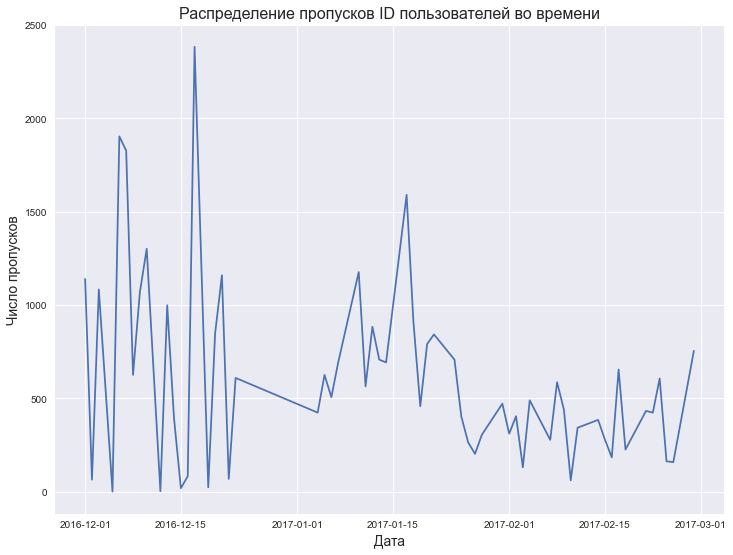

In [20]:
retail_data[retail_data['customer_id'].isnull()].groupby('date').agg({'item_id': 'count'})\
                        .plot(title='Распределение пропусков ID пользователей во времени', legend=False)
plt.xlabel('Дата')
plt.ylabel('Число пропусков')
plt.legend
plt.show()

Во-первых, заметим, что у нас очень неравномерное распределение данных по магазинам - больше трех четвертей датасета относятся к одному Shop 0. Мы подробнее исследуем этот факт далее, в ходе EDA. Во-вторых, в этом же магазине большая часть пропусков. Причем на пропуски приходится окло 40% всех товаров, купленных в этом магазине. В-третьих, распределение пропусков во времени не похоже на временный сбой - хначительные колебания от нуля до нескольких сотен значений наблюдаются в течение всего периода. Также, судя по графику, у нас нет данных для нескольких дней около Нового года - на это также обратим внимание в ходе EDA. В целом, эти пропуски не выглядят случайными, скорее, это какая-то особенность продаж в Shop 0 и некоторых других магазинах. Проверим, как пропуски соотносятся с программой лояльности.

In [21]:
retail_data[retail_data['customer_id'].isnull()].groupby('is_loyal').agg({'item_id': 'count'})

,item_id
is_loyal,
0.0,36148


Ни один пользователь с неизвестным ID не является участником программы лояльности. Проверим, есть ли покупки, совершенные в одно время пользователями с ID и без ID.

In [22]:
same_time = retail_data[~retail_data['customer_id'].isnull()].groupby('purchase_dt', as_index=False).agg({'item_id': 'count'})\
    .merge(retail_data[retail_data['customer_id'].isnull()].groupby('purchase_dt', as_index=False).agg({'item_id': 'count'}),
          on='purchase_dt')

print(same_time.shape)
same_time.head()

(64, 3)


,purchase_dt,item_id_x,item_id_y
0,2016-12-01 14:33:00,14,2
1,2016-12-01 14:34:00,31,3
2,2016-12-02 11:45:00,16,11
3,2016-12-02 14:23:00,1,19
4,2016-12-02 14:42:00,12,1


In [23]:
print(f'''
Число товарных позиций, купленных пользователями с ID и без ID в одно время: 
{np.sum(same_time['item_id_x'])} и {np.sum(same_time['item_id_y'])}
''')


Число товарных позиций, купленных пользователями с ID и без ID в одно время: 
994 и 1492



Если бы у нас были данные об очень большом числе покупок, совершенных пользователями с ID и без ID в одно и то же время, то мы могли бы предположить, что одни и те же чеки по какой-то причине не были полностью "записаны" на пользователя. Однако их число относительно невелико - оно вполне может объясняться одновременными покупками.  
Таким образом, мы считаем, что покупки без ID покупателя - это какая-то особенность нашего бизнеса, например, продажи людям "с улицы". Отбрасывать их совсем нельзя - это очень большая часть данных, следовательно, их надо заполнять. Можно предложить несколько вариантов заполнения:
1. Заполнить их все одним условным значением. Это вариант плох тем, что мы, по сути, получим одного "суперпокупателя", которого не сможем учитывать в дальнейших агрегированных расчетах (например, для расчета среднего чека);
2. Заполнить их все разными условными значениями. Этот вариант плох по той же причине - у нас получится множество мелких покупателей, которые также не будут вписываться в общие расчеты;
3. Агрегировать покупки с неизвестным ID по времени и для каждой временной отметки ввести свое условное значение.  

Посмотрим, как третий вариант отразится на данных. Для этого рассчитаем число товарных позиций в чеках известных пользователей и для каждой временной отметки у неизвестных и сравним значения.

In [24]:
id_checks = retail_data[~retail_data['customer_id'].isnull()].groupby(['customer_id', 'purchase_dt'])\
                        .agg({'item_id': 'count'}).sort_values('item_id', ascending=False)
no_id_checks = retail_data[retail_data['customer_id'].isnull()].groupby(['shop_id', 'purchase_dt'])\
                .agg({'item_id': 'count'}).sort_values('item_id', ascending=False)
    

print('Известные ID')
display(id_checks.head())
display(id_checks.describe())
print()
print('Неизвестные ID')
display(no_id_checks.head())
display(no_id_checks.describe())

Известные ID


,,item_id
customer_id,purchase_dt,
23016.0,2017-02-02 17:06:00,244
18760.0,2017-01-06 16:41:00,171
21143.0,2017-01-05 15:56:00,155
18853.0,2016-12-05 16:24:00,152
18180.0,2017-01-07 12:28:00,149


,item_id
count,4121.000000
mean,16.538219
std,19.069216
min,1.000000
25%,3.000000
50%,11.000000
75%,22.000000
max,244.000000



Неизвестные ID


item_id
shop_id purchase_dt                 
Shop 0  2016-12-06 16:57:00      675
        2016-12-09 14:09:00      651
        2016-12-10 14:59:00      614
        2016-12-07 15:28:00      601
        2016-12-06 09:58:00      597

,item_id
count,629.000000
mean,57.468998
std,123.472944
min,1.000000
25%,1.000000
50%,2.000000
75%,48.000000
max,675.000000


Как видно, третий путь тоже плох: в одну временную отметку совершается много покупок и мы рискуем добавить несколько "суперпользователей".  
Этот способ можно модифицировать, если вводить "условного пользователя" не для каждой временной отметки, а для каких-то более мелких групп, например, приписывать один ID на каждые 11 товарных позиций (медианное значение для известных пользователей). Мы можем рассчитывать, что таким образом получим суммы наших "искусственных" чеков, не сильно отдаленные от средних значений тех данных, которые у нас есть. Чтобы иметь возможность быстро отсеить "искусственные" ID, зададим их в виде `new00000`. Также заменим тип данных в столбце `customer_id` на `str`.

In [25]:
split_number = np.ceil(len(retail_data[retail_data['customer_id'].isnull()]) / id_checks.median())
split_by_average_check = np.array_split(retail_data[retail_data['customer_id'].isnull()], 3500, axis=0)

for counter, df in enumerate(split_by_average_check):
    new_id = 'new' + str(counter).zfill(5)
    df.fillna(value=new_id, inplace=True) 

id_filled = pd.concat(split_by_average_check)

In [26]:
id_given = retail_data[~retail_data['customer_id'].isnull()]
id_given['customer_id'] = id_given['customer_id'].astype(int).astype(str)
data = pd.concat([id_filled, retail_data[~retail_data['customer_id'].isnull()]])
data.sort_index(inplace=True)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104302 entries, 0 to 105334
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   purchase_id  104302 non-null  object        
 1   item_id      104302 non-null  object        
 2   quantity     104302 non-null  int64         
 3   purchase_dt  104302 non-null  datetime64[ns]
 4   customer_id  104302 non-null  object        
 5   shop_id      104302 non-null  object        
 6   is_loyal     104302 non-null  float64       
 7   date         104302 non-null  object        
 8   hour         104302 non-null  int64         
 9   dow          104302 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 8.8+ MB


Пропуски заполнены, однако надо иметь в виду, что показатели для "искусственных" пользователей могут отличаться от цифр для известных пользователей. В дальнейшем можно будет проверить качество заполнения по сумме чеков. Далее мы будем работать с датафреймом `data`.

### Обработка нулей и отрицательных значений

В столбце `quantity` есть отрицательные и нулевые значения, противоречащие логике задачи. Попробуем их интерпретировать.

In [28]:
print(f'''
Число отрицательных значений: {data[data['quantity'] < 0]['purchase_id'].count()}
Число нулевых значений: {data[data['quantity'] == 0]['purchase_id'].count()}
''')


Число отрицательных значений: 2076
Число нулевых значений: 32362



In [29]:
data['quantity'].describe()

count    104302.000000
mean          7.883003
std         329.565540
min      -74216.000000
25%           0.000000
50%           2.000000
75%           7.000000
max       74214.000000
Name: quantity, dtype: float64

In [30]:
data[np.logical_or(data['quantity'] == -74216, data['quantity'] == 74214)]

,purchase_id,item_id,quantity,purchase_dt,customer_id,shop_id,is_loyal,date,hour,dow
49411,C541433,23166,-74216,2017-01-18 10:17:00,18025.0,Shop 0,0.0,2017-01-18,10,2
69074,541431,23166,74214,2017-01-18 10:01:00,18025.0,Shop 0,0.0,2017-01-18,10,2


Отрицательные значения, вероятно, обозначают возвраты. В таком случае у нас должны быть и покупки такого же количества того же товара. Впрочем, самые большие совпадают не полностью, хотя и близки, как будто вернули больше, чем купили. По ним можно предположить, что это отмена покупки (отрицательная транзакция произошла там же, с тем же покупателем, через 16 минут после положительной), а также что все отрицательные транзакции имеют ID, начинающийся с "C". проверим это. 

In [31]:
data[np.logical_and(data['quantity'] < 0, ~data['purchase_id'].str.contains('C'))]

,purchase_id,item_id,quantity,purchase_dt,customer_id,shop_id,is_loyal,date,hour,dow
468,537032,21275,-31,2016-12-03 16:50:00,new00014,Shop 0,0.0,2016-12-03,16,5
503,540119,22865,-61,2017-01-05 10:07:00,new00015,Shop 0,0.0,2017-01-05,10,3
910,540241,35957,-940,2017-01-05 15:17:00,new00029,Shop 0,0.0,2017-01-05,15,3
1784,537009,84534B,-81,2016-12-03 15:38:00,new00058,Shop 0,0.0,2016-12-03,15,5
1928,540010,22501,-101,2017-01-04 11:13:00,new00063,Shop 0,0.0,2017-01-04,11,2
...,...,...,...,...,...,...,...,...,...,...
103022,542225,85096,-60,2017-01-26 13:10:00,new03421,Shop 0,0.0,2017-01-26,13,3
103534,540558,21258,-30,2017-01-10 10:04:00,new03438,Shop 0,0.0,2017-01-10,10,1
104588,541487,85118,-36,2017-01-18 13:19:00,new03474,Shop 0,0.0,2017-01-18,13,2
104960,540564,22617,-2601,2017-01-10 10:36:00,new03485,Shop 0,0.0,2017-01-10,10,1


In [32]:
data[np.logical_and(data['quantity'] >= 0, data['purchase_id'].str.contains('C'))]

,purchase_id,item_id,quantity,purchase_dt,customer_id,shop_id,is_loyal,date,hour,dow


У нас есть отрицательные транзакции с ID без "C", но нет положительных с ID с "C". Приверим, сколько у нас пар отрицательных и неотрицательных транзакций. Для этого мы будем оперировать таблицей с незаполненными дубликатами, так как иначе мы не можем включить пользователей в ключ - наши "искусственные" пользователи могут исказить картину.

In [33]:
returns = retail_data.groupby(['item_id', 'customer_id', 'shop_id']).agg({'quantity': ['count', 'min', 'max']})
returns.columns = ['count', 'min', 'max']
returns[np.logical_and(returns['count'] >= 2, returns['min'] < 0)].sort_values('min').head(15)

,,,count,min,max
item_id,customer_id,shop_id,,,
23166,18025.0,Shop 0,2,-74216,74214
15036,18587.0,Shop 0,2,-601,599
85123A,21692.0,Shop 0,4,-501,499
20733,21692.0,Shop 0,3,-301,299
85232B,23083.0,Shop 19,2,-241,239
22630,19835.0,Shop 6,3,-193,191
84754,21192.0,Shop 0,2,-145,143
35924,19477.0,Shop 0,5,-145,143
21877,22363.0,Shop 0,2,-145,143


In [34]:
returns[np.logical_and(returns['count'] >= 2, returns['min'] == -1)]

,,,count,min,max
item_id,customer_id,shop_id,,,


In [35]:
returns[np.logical_and(returns['count'] >= 2, returns['min'] == -2)].head()

,,,count,min,max
item_id,customer_id,shop_id,,,
15056N,19456.0,Shop 0,3,-2,35
15056P,19456.0,Shop 0,2,-2,47
16258A,21193.0,Shop 0,3,-2,0
20685,18427.0,Shop 0,3,-2,0
20705,21824.0,Shop 0,3,-2,23


Самые большие по модулю отрицательные значения имеют положительные пары, причем в каждом случае отрицательное значение по модулю больше на 2. При этом у нас нет значений равных -1. Посчитаем самые популярные значения.

In [36]:
Counter(data['quantity'].to_list()).most_common(10)

[(0, 32362),
 (1, 16137),
 (11, 10265),
 (5, 7931),
 (2, 7444),
 (3, 6796),
 (23, 4122),
 (9, 2959),
 (4, 2425),
 (7, 2403)]

Мы видим, что наиболее часто встречающееся число покупок в наших данных - 0, за ним примерно вдвое меньше - 1. При этом у нас нет значений, равных -1, но есть -2. Все аномалии в количестве могут быть объяснены, если мы предположим, что у нас точка отсчета - это не 0, а -1. Тогда, мы получаем ожидаемое:
- нет нулевых значений (поскольку нет -1);
- больше всего покупок - по одной единице, и большие значения - покупки по 12 и 24 (часто покупают дюжинами);
- равные по модулю положительные и отрицательные транзакции, следовательно, последние мы считаем возвратами/отменами.  

По какой причине 0 "съехал" на -1 - непонятно, возможно, это технический сбой или некая неочевидная особенность учета товаров. Для компенсации этого добавим к количеству в нашей рабочей таблице 1. Отрицательные значения мы убирать не будем, поскольку они компенсируют положительные при подсчете суммарных продаж и т.п. При необходимости мы будем их отсеивать.

Для дополнительной проверки посмотрим, в скольких магазинах есть нули.

In [37]:
zero_shops = data[data['quantity'] == 0]['shop_id'].unique()
len(zero_shops)

17

In [38]:
data[~data['shop_id'].isin(zero_shops)].shape

(722, 10)

In [39]:
data[~data['shop_id'].isin(zero_shops)].head(10)

,purchase_id,item_id,quantity,purchase_dt,customer_id,shop_id,is_loyal,date,hour,dow
68,545065,22505,3,2017-02-27 14:43:00,18110.0,Shop 2,0.0,2017-02-27,14,0
218,540267,21238,95,2017-01-06 11:12:00,18094.0,Shop 2,0.0,2017-01-06,11,4
554,542276,22652,9,2017-01-27 10:19:00,18443.0,Shop 27,0.0,2017-01-27,10,4
802,540267,21239,95,2017-01-06 11:12:00,18094.0,Shop 2,0.0,2017-01-06,11,4
1103,542276,82600,11,2017-01-27 10:19:00,18443.0,Shop 27,0.0,2017-01-27,10,4
1141,541975,20961,9,2017-01-24 14:24:00,new00037,Shop 25,0.0,2017-01-24,14,1
1152,542276,85150,5,2017-01-27 10:19:00,18443.0,Shop 27,0.0,2017-01-27,10,4
1403,544108,22193,11,2017-02-16 10:53:00,18332.0,Shop 21,0.0,2017-02-16,10,3
1445,544108,22629,23,2017-02-16 10:53:00,18332.0,Shop 21,0.0,2017-02-16,10,3
1446,541267,21110,23,2017-01-17 10:37:00,18458.0,Shop 9,0.0,2017-01-17,10,1


In [40]:
data[~data['shop_id'].isin(zero_shops)]['shop_id'].unique()

array(['Shop 2', 'Shop 27', 'Shop 25', 'Shop 21', 'Shop 9', 'Shop 28',
       'Shop 29', 'Shop 17', 'Shop 13', 'Shop 26', 'Shop 24', 'Shop 15',
       'Shop 23', 'Shop 30'], dtype=object)

In [41]:
non_null_returns = data[~data['shop_id'].isin(zero_shops)]\
                    .groupby(['item_id', 'customer_id', 'shop_id']).agg({'quantity': ['count', 'min', 'max']})
non_null_returns.columns = ['count', 'min', 'max']
non_null_returns[non_null_returns['min'] < 0].sort_values('min').head(15)

,,,count,min,max
item_id,customer_id,shop_id,,,
72802B,new00691,Shop 23,1,-55,-55
22474,18345.0,Shop 21,1,-33,-33
84792,18345.0,Shop 21,1,-25,-25
22087,22000.0,Shop 2,4,-19,17
22333,18113.0,Shop 2,1,-8,-8
22094,18113.0,Shop 2,1,-6,-6
22325,22000.0,Shop 2,3,-4,2
21217,18113.0,Shop 2,1,-2,-2


В тринадцати магазинах нет нулевых значений, но в одном из них есть такой же "перекос" между положительными и отрицательными значениями, так что, вероятно, там есть та же проблема с указанием количества, а отсутствие нулей (то есть единичных покупок) объясняется небольшой выборкой либо спецификой магазина, например, склада стройматериалов. В любом случае, даже если мы исказим таким образом данные, это небольшая их часть - всего 700 из 100 с лишним тысяч. По этой же таблице видно, что у нас есть непарные отрицательные значения, по-видимому, возвраты того, что куплено раньше нашего периода. Мы не будем их удалять, предполагая, что они более-менее компенсируют те товары, которые куплены в конце периода и будут возвращены в следующем.

In [42]:
data['quantity'] = data['quantity'] + 1

In [43]:
retail_data['quantity'] = retail_data['quantity'] + 1

### Расчет стоимости каждой позиции

Для расчета стоимости каждой позиции объединим датафрейм с данными и датафрейм с медианной ценой каждого товара, а затем умножим ее на количество.

In [44]:
prices = prices.reset_index()
data = data.merge(prices[['product_id', 'median']], how='left', left_on='item_id', right_on='product_id')

In [45]:
f'Позиций с неизвестной ценой: {data["median"].isna().sum()}'

'Позиций с неизвестной ценой: 0'

In [46]:
data['price'] = data['quantity'] * data['median']
data.drop(columns=['product_id', 'median'], inplace=True)
data.head()

,purchase_id,item_id,quantity,purchase_dt,customer_id,shop_id,is_loyal,date,hour,dow,price
0,538280,21873,12,2016-12-10 12:50:00,18427.0,Shop 0,0.0,2016-12-10,12,5,19.56
1,538862,22195,1,2016-12-14 14:11:00,22389.0,Shop 0,1.0,2016-12-14,14,2,3.29
2,538855,21239,8,2016-12-14 13:50:00,22182.0,Shop 0,1.0,2016-12-14,13,2,13.04
3,543543,22271,1,2017-02-09 15:33:00,23522.0,Shop 0,1.0,2017-02-09,15,3,4.37
4,543812,79321,1,2017-02-13 14:40:00,23151.0,Shop 0,1.0,2017-02-13,14,0,5.75


Стоимость каждой позиции добавлена.

### Анализ выбросов

Рассмотрим, как распределены цены позиций, чтобы оценить, что можно считать выбросами.

In [47]:
data_sales = data[data['price'] >= 0]
data_sales.price.describe()

count    102266.000000
mean         28.070442
std         266.781342
min          -0.000000
25%           4.150000
50%          10.400000
75%          24.850000
max       77183.600000
Name: price, dtype: float64

In [48]:
f'Число товаров с нулевой ценой: {len(data_sales[data["price"] == 0]["price"])}'

'Число товаров с нулевой ценой: 59'

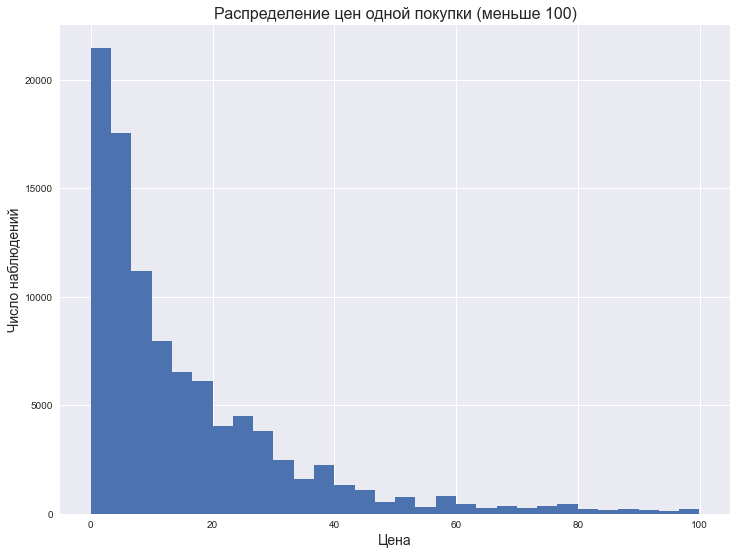

In [49]:
data_sales[data['price'] < 100]['price'].hist(bins=30);
plt.title('Распределение цен одной покупки (меньше 100)')
plt.xlabel('Цена')
plt.ylabel('Число наблюдений');

In [50]:
limit = data_sales['price'].quantile(q=0.75)\
                + 1.5 * (data_sales['price'].quantile(q=0.75)\
                - data_sales['price'].quantile(q=0.25))
print(f'Третий квартиль плюс полтора межквартильных размаха: {limit:.2f}')
data[data['price'] > limit]

Третий квартиль плюс полтора межквартильных размаха: 55.90


,purchase_id,item_id,quantity,purchase_dt,customer_id,shop_id,is_loyal,date,hour,dow,price
18,543193,22839,4,2017-02-04 12:18:00,19404.0,Shop 0,0.0,2017-02-04,12,5,88.24
33,544573,22303,36,2017-02-21 13:40:00,18300.0,Shop 4,0.0,2017-02-21,13,1,135.18
53,541220,22936,72,2017-01-14 14:11:00,19835.0,Shop 6,0.0,2017-01-14,14,5,234.00
57,544076,21671,24,2017-02-15 15:00:00,22086.0,Shop 0,1.0,2017-02-15,15,2,59.04
75,537640,21212,104,2016-12-07 15:31:00,new00001,Shop 0,0.0,2016-12-07,15,2,130.00
...,...,...,...,...,...,...,...,...,...,...,...
104246,541813,22969,24,2017-01-21 15:36:00,23918.0,Shop 0,1.0,2017-01-21,15,5,56.88
104259,538354,48138,6,2016-12-10 15:45:00,22552.0,Shop 0,1.0,2016-12-10,15,5,85.68
104265,536982,22734,13,2016-12-03 14:27:00,new03498,Shop 0,0.0,2016-12-03,14,5,65.78
104279,539750,22734,21,2016-12-21 15:40:00,new03498,Shop 0,0.0,2016-12-21,15,2,106.26


In [51]:
print(f'''
90, 95 и 99 перцентили: {np.percentile(data['price'], [90, 95, 99])}
''')


90, 95 и 99 перцентили: [ 45.8     89.394  280.4982]



In [52]:
limit_std = data['price'].mean() + 3 * data['price'].std()
data[data['price'] > limit]

,purchase_id,item_id,quantity,purchase_dt,customer_id,shop_id,is_loyal,date,hour,dow,price
18,543193,22839,4,2017-02-04 12:18:00,19404.0,Shop 0,0.0,2017-02-04,12,5,88.24
33,544573,22303,36,2017-02-21 13:40:00,18300.0,Shop 4,0.0,2017-02-21,13,1,135.18
53,541220,22936,72,2017-01-14 14:11:00,19835.0,Shop 6,0.0,2017-01-14,14,5,234.00
57,544076,21671,24,2017-02-15 15:00:00,22086.0,Shop 0,1.0,2017-02-15,15,2,59.04
75,537640,21212,104,2016-12-07 15:31:00,new00001,Shop 0,0.0,2016-12-07,15,2,130.00
...,...,...,...,...,...,...,...,...,...,...,...
104246,541813,22969,24,2017-01-21 15:36:00,23918.0,Shop 0,1.0,2017-01-21,15,5,56.88
104259,538354,48138,6,2016-12-10 15:45:00,22552.0,Shop 0,1.0,2016-12-10,15,5,85.68
104265,536982,22734,13,2016-12-03 14:27:00,new03498,Shop 0,0.0,2016-12-03,14,5,65.78
104279,539750,22734,21,2016-12-21 15:40:00,new03498,Shop 0,0.0,2016-12-21,15,2,106.26


Как видно, разброс значений очень значительный: при среднем в 29 стандартное отклонение 267, максимум - больше 77 тысяч, 95% значений меньше 90. Стандартный способ отсеивания выбросов, основанный на межквартильном размахе, исключает почти 9000 значений, что составляет существенную часть наших данных. Поэтому кажется более обоснованным отсеить данные, отличающиеся от среднего больше, чем на три стандартных отклонения (меньше 4% данных). Одновременно мы исключим отрицательные значения, которые по модулю больше этого лимита, чтобы отсеить соответствующие возвраты.

In [53]:
data = data[np.logical_and(data['price'] < limit,
                           data['price'] > -1 * limit)]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95269 entries, 0 to 104301
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   purchase_id  95269 non-null  object        
 1   item_id      95269 non-null  object        
 2   quantity     95269 non-null  int64         
 3   purchase_dt  95269 non-null  datetime64[ns]
 4   customer_id  95269 non-null  object        
 5   shop_id      95269 non-null  object        
 6   is_loyal     95269 non-null  float64       
 7   date         95269 non-null  object        
 8   hour         95269 non-null  int64         
 9   dow          95269 non-null  int64         
 10  price        95269 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 8.7+ MB


In [54]:
data.describe()

,quantity,is_loyal,hour,dow,price
count,95269.000000,95269.000000,95269.000000,95269.000000,95269.000000
mean,5.085516,0.223451,13.097261,2.636052,12.847573
std,10.324268,0.416561,2.427832,1.621608,12.680204
min,-1430.000000,0.000000,7.000000,0.000000,-55.800000
25%,1.000000,0.000000,11.000000,1.000000,3.555000
50%,2.000000,0.000000,13.000000,3.000000,8.500000
75%,6.000000,0.000000,15.000000,4.000000,19.680000
max,1287.000000,1.000000,20.000000,5.000000,55.800000


### Вывод
1. В ходе предобработки были обработаны дубликаты - удалены в основной таблице и заменены медианой в таблице цен.
2. Пропуски в ID пользователей, возникшие, скорее всего, не из-за случайной ошибки, были заполнены "искусственными" ID, каждому из которых соответствует медианное число позиций в чеке.
3. Нулевые значения количества товара возникли из-за смещения нуля в этом столбце на -1, для исправления ко всем значениям в столбце мы прибавили единицу. Отрицательные значения обозначают возвраты и отмены покупок - мы оставили их в таблице и будем учитывать в дальнейшем.
4. В таблицу была добавлена стоимость каждой позиции на основе количества и медианной цены единицы товара.
5. Из данных исключен 1% самых дорогих покупок.
6. В результате у нас есть таблица из 103181 записи, типы данных приведены к нужным, названия столбцов исправлены, данные готовы к анализу.

---

[Наверх](#contents)

---

## 3. Исcледовательский анализ данных <a id='eda'></a> 

### Распределение данных во времени

In [55]:
def time_distribution(col, name, df=data):
    agg_by_time = df.pivot_table(index=col, values='purchase_id', aggfunc='count')
    ax = agg_by_time.plot(title=f'Распределение покупок во времени ({name})', legend=False, kind='bar')
    plt.xlabel(name)
    plt.ylabel('число покупок')
    return ax

In [56]:
timeline = data.pivot_table(index='date', values='purchase_id', aggfunc='count').reset_index()
timeline

,date,purchase_id
0,2016-12-01,2790
1,2016-12-02,1834
2,2016-12-03,1967
3,2016-12-05,2481
4,2016-12-06,3654
...,...,...
63,2017-02-23,1464
64,2017-02-24,1177
65,2017-02-25,906
66,2017-02-27,736


In [57]:
timeline.describe()

,purchase_id
count,68.000000
mean,1401.014706
std,655.234366
min,253.000000
25%,966.250000
50%,1313.000000
75%,1620.000000
max,3654.000000


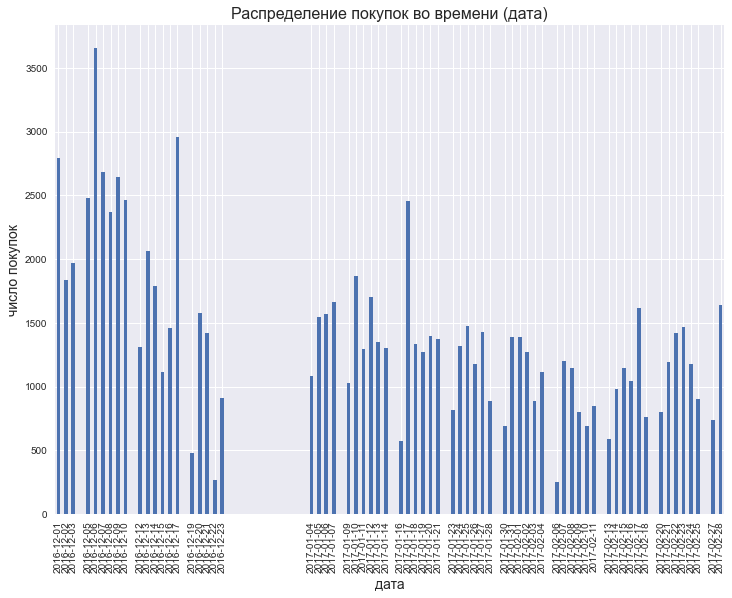

In [58]:
time_distribution('date', 'дата');

Данные охватывают период c 1 декабря по 28 февраля, за исключением новогодних праздников (с 23 декабря по 3 января) и воскресений, когда магазины, по-видимому, закрыты. В среднем за день совершается 1400 покупок, однако разброс весьма большой - максимальное значение составляет 3654, минимальное - 253, причем значения сильно колеблются даже в соседние дни. Наиболее высокие значения относятся к началу периода, и вообще в декабре покупок, кажется, было больше. После Нового года значения стабильнее - за двумя исключениями, они колеблются от 500 до 1500 продаж в день.

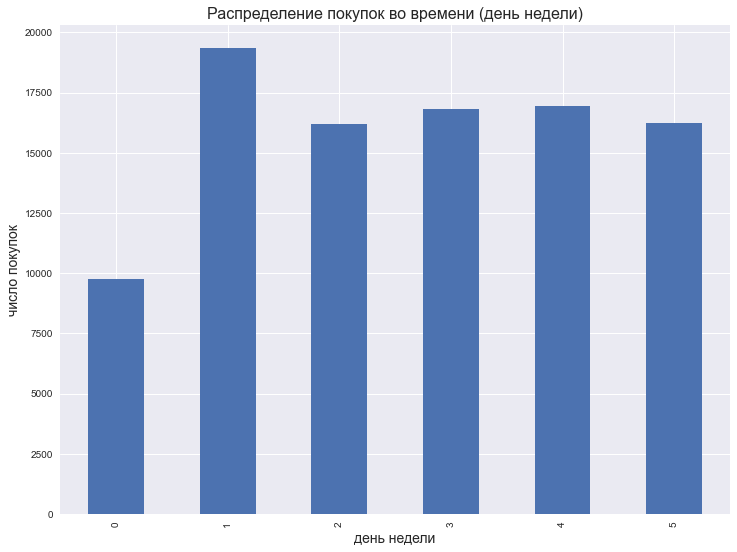

In [59]:
time_distribution('dow', 'день недели');

Как уже было сказано, у нас нет данных о воскресеньях. Минимальное число покупок относится к понедельникам (около 10000), во вторник удваивается и достигает пика - почти 20000, затем снижается и во все остальные дни держится примерно на уровне 16-17 тысяч.

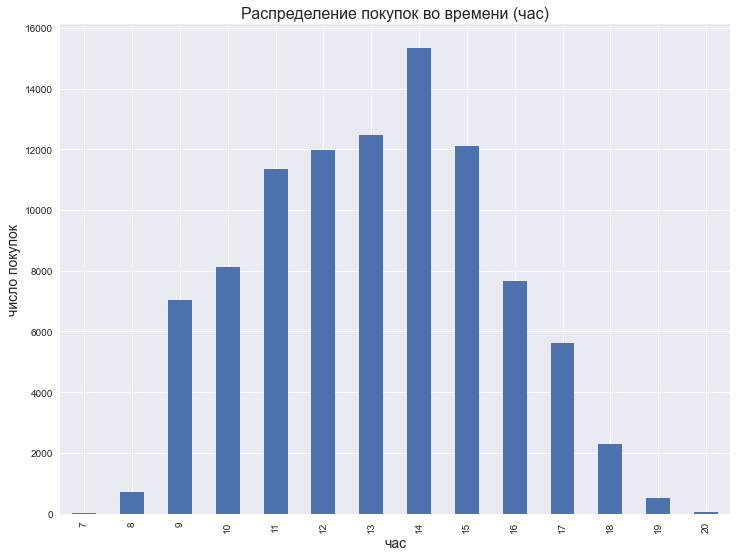

In [60]:
time_distribution('hour', 'час');

Наши магазины работают с 8 до 20 часов, большая часть покупок совершается до 15 часов, между 14 и 15 часами их число достигает пика, затем достаточно быстро снижается к вечеру.

### Изучение поведения пользователей

Для характеристики поведения покупателей сгруппируем данные по покупателям и рассчитаем следующие показатели:
- сколько покупок совершает каждый покупатель за весь период?
- сколько раз каждый покупатель посещал нашу сеть?
- в скольких магазинах он побывал?
- какова доля лояльных покупателей и какая доля покупок приходится на них?
- какова доля неизвестных покупателей (тех, для которых заполнены пропуски в ID) и какая доля покупок приходится на них?

In [61]:
customer_data = data.groupby('customer_id', as_index=False).agg({'purchase_id': 'count', 'purchase_dt': 'nunique', 
                                        'shop_id': 'nunique', 'is_loyal': 'first'})
customer_data.columns = ['customer_id', 'purchases', 'visits', 'shops_visited', 'is_loyal']
customer_data['customer_id'] = customer_data['customer_id'].astype(str)
customer_data.sort_values('purchases', ascending=False).head(10)

,customer_id,purchases,visits,shops_visited,is_loyal
138,18427.0,754,46,1,0.0
648,20285.0,739,39,1,0.0
1523,23520.0,733,29,1,1.0
832,20990.0,631,33,1,0.0
733,20590.0,444,26,1,0.0
756,20718.0,393,12,1,0.0
229,18768.0,338,19,1,0.0
1604,23797.0,316,7,1,1.0
1527,23529.0,290,34,1,1.0
226,18760.0,281,7,1,0.0


In [62]:
customer_data.describe()

,purchases,visits,shops_visited,is_loyal
count,5147.000000,5147.000000,5147.000000,5147.000000
mean,18.509617,7.288712,1.027783,0.107830
std,32.568712,3.867384,0.166715,0.310195
min,1.000000,1.000000,1.000000,0.000000
25%,10.000000,3.000000,1.000000,0.000000
50%,10.000000,9.000000,1.000000,0.000000
75%,11.000000,10.000000,1.000000,0.000000
max,754.000000,46.000000,3.000000,1.000000


In [63]:
# условие для отсева "искусственных пользователей"
filter_new = ~customer_data['customer_id'].str.contains('new')

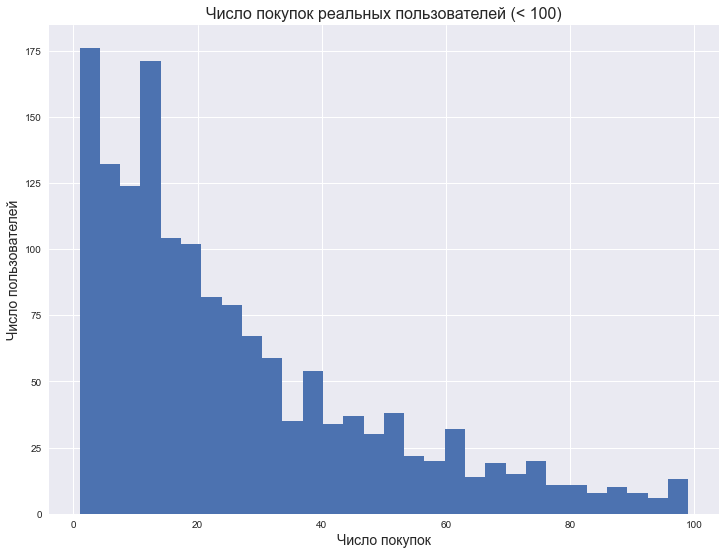

In [64]:
customer_data[(customer_data['purchases'] < 100) & filter_new]['purchases'].hist(bins=30)
plt.title('Число покупок реальных пользователей (< 100)')
plt.xlabel('Число покупок')
plt.ylabel('Число пользователей');

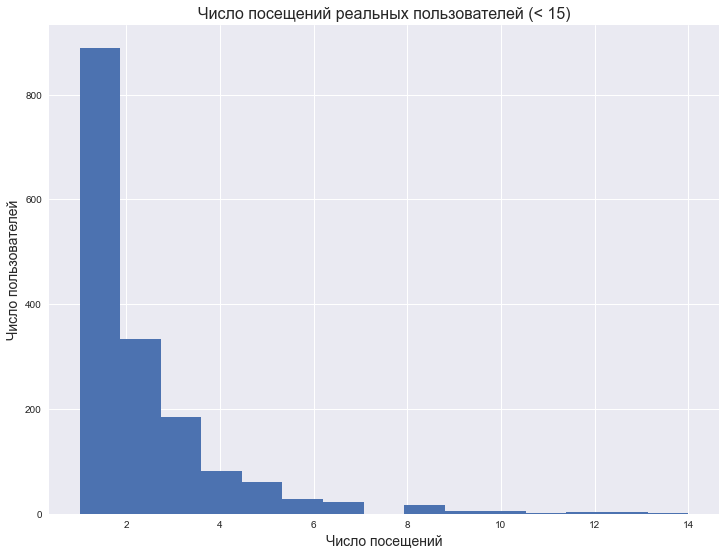

In [65]:
customer_data[(customer_data['visits'] <= 15) & filter_new]['visits'].hist(bins=15)
plt.title('Число посещений реальных пользователей (< 15)')
plt.xlabel('Число посещений')
plt.ylabel('Число пользователей');

In [66]:
print(f'''
Доля лояльных известных пользователей: {customer_data[filter_new]['is_loyal'].mean():.2f}
Доля покупок лояльных пользователей: {data['is_loyal'].mean():.2f}
''')


Доля лояльных известных пользователей: 0.34
Доля покупок лояльных пользователей: 0.22



1. Среди покупателей (правда, с учетом "искусственных") в наших магазинах есть достаточно много возвращающихся - меньше четверти посещали в интересующий нас период наши магазины меньше трех раз, медианное число визитов - 10. При этом есть несколько покупателей, совершающих покупки очень часто - максимум равен 46. Такие пользователи купили гораздо больше товаров, чем прочие, с рекордом в 754 позиции при медианном значении в 10 позиций. 
2. Если рассматривать только "реальных" пользователей, то видно, что наиболее часто они посещают магазин единожды, число пользователей плавно убывает примерно до 10 визитов, большие значения крайне редки. 
3. Число покупок так имеет имеет максимум на 1, однако оно убывает не плавно, мы видим, например, локальный максимум в районе 10-15 значений. 
4. Больше 75% посещают единственный магазин, даже если совершают очень много покупок.
5. Доля лояльных пользователей среди известных - 34%, при этом на них приходится 22% покупок, что объясняется большим количеством покупок "нелояльных" неизвестных пользователей.  

На следующем этапе работы расчитаем основные метрики и сравним их значения для разных магазинов.

---

[Наверх](#contents)

---

## 3. Расчет основных метрик и сравнение магазинов <a id='metrics'></a>

### Расчет среднего чека

Рассчитаем сумму каждого чека, объединив данные покупок с одинаковыми ID покупателя и временем.

In [67]:
checks_data = data.pivot_table(index=['customer_id', 'purchase_dt'], aggfunc={
    'quantity': 'count',
    'shop_id': 'first',
    'is_loyal': 'first',
    'date': 'first',
    'price': 'sum'
})

In [68]:
checks_data

date  is_loyal    price  quantity  \
customer_id purchase_dt                                                    
18026.0     2016-12-07 14:57:00  2016-12-07       0.0  742.255        27   
            2017-01-26 14:30:00  2017-01-26       0.0  687.105        27   
18027.0     2016-12-16 19:09:00  2016-12-16       0.0  151.200         5   
            2017-01-25 10:42:00  2017-01-25       0.0   43.110         2   
18029.0     2017-02-02 16:01:00  2017-02-02       0.0  434.830        17   
...                                     ...       ...      ...       ...   
new03499    2017-01-05 11:30:00  2017-01-05       0.0    2.520         1   
            2017-01-10 16:25:00  2017-01-10       0.0    2.500         1   
            2017-01-17 17:44:00  2017-01-17       0.0    3.720         1   
            2017-02-16 15:56:00  2017-02-16       0.0   13.160         1   
            2017-02-28 16:50:00  2017-02-28       0.0   23.740         1   

                                 shop_id  
customer_id purchase_dt                   
18026.0     2016-12-07 14:57:00  Shop 15  
            2017-01-26 14:30:00  Shop 15  
18027.0     2016-12-16 19:09:00  Shop 22  
            2017-01-25 10:42:00  Shop 22  
18029.0     2017-02-02 16:01:00   Shop 5  
...                                  ...  
new03499    2017-01-05 11:30:00   Shop 0  
            2017-01-10 16:25:00   Shop 0  
            2017-01-17 17:44:00   Shop 0  
            2017-02-16 15:56:00   Shop 0  
            2017-02-28 16:50:00   Shop 0  

[37515 rows x 5 columns]

In [69]:
checks_no_refund = checks_data[checks_data['price'] > 0]

In [70]:
checks_no_refund.describe()

,is_loyal,price,quantity
count,36662.000000,36662.000000,36662.000000
mean,0.027685,34.043671,2.550543
std,0.164072,124.809478,7.517130
min,0.000000,0.180000,1.000000
25%,0.000000,2.500000,1.000000
50%,0.000000,4.970000,1.000000
75%,0.000000,11.500000,1.000000
max,1.000000,3653.200000,242.000000


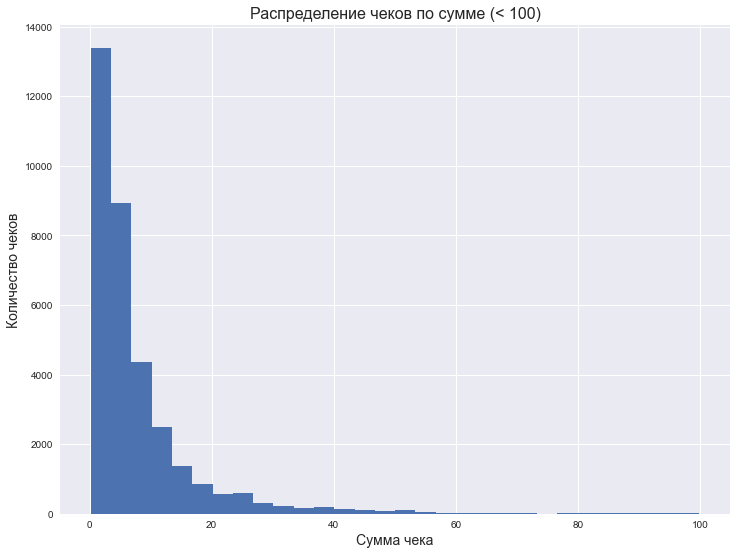

In [71]:
checks_no_refund[checks_data['price'] < 100]['price'].hist(bins=30)
plt.title('Распределение чеков по сумме (< 100)')
plt.xlabel('Сумма чека')
plt.ylabel('Количество чеков');

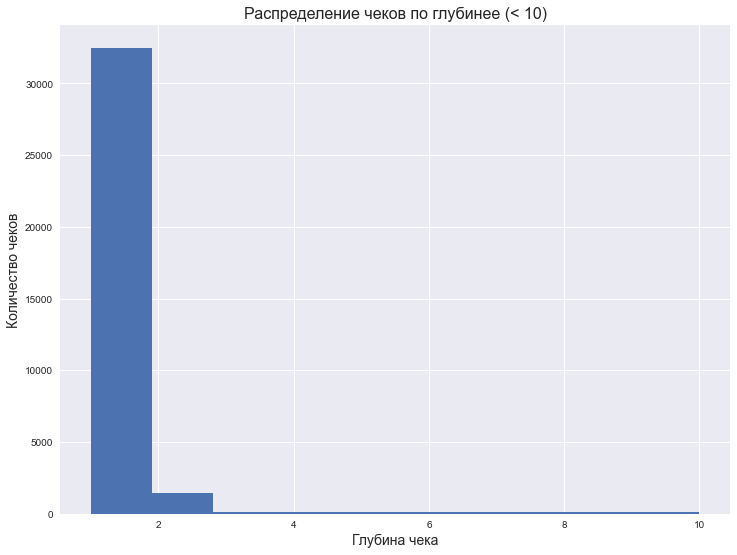

In [72]:
checks_no_refund[checks_data['quantity'] <= 10]['quantity'].hist(bins=10)
plt.title('Распределение чеков по глубинее (< 10)')
plt.xlabel('Глубина чека')
plt.ylabel('Количество чеков');

Абсолютное большинство чеков состоят из одной позиции, число чеков даже с тремя покупками очень мало, хотя есть и выбросы вплоть до 244 позиций. Медианная сумма чека - 5, средняя - 34. Значения сильно разбросаны, при преобладании небольших покупок есть чеки в 3.6 тыс. у.е. 

### Сравнение магазинов

In [73]:
shops_compare = data.groupby('shop_id').agg({
    'customer_id': 'nunique',
    'purchase_dt': 'count',
    'price': 'mean',
    'quantity': 'mean',
    'is_loyal': 'mean'
}).sort_values('purchase_dt', ascending=False)

In [74]:
shops_compare

,customer_id,purchase_dt,price,quantity,is_loyal
shop_id,,,,,
Shop 0,4975,89149,12.167589,4.758887,0.237726
Shop 4,43,1498,20.675838,9.288385,0.000000
Shop 1,37,1327,23.558843,10.123587,0.000000
Shop 6,103,791,21.619817,7.624526,0.000000
Shop 8,11,518,19.709073,7.054054,0.119691
Shop 12,10,258,23.527287,10.930233,0.000000
Shop 7,7,253,25.019368,11.679842,0.000000
Shop 10,8,252,26.120397,8.932540,0.000000
Shop 18,5,217,21.721682,7.391705,0.000000


Магазин Shop 0 отличается от всех прочих: для него больше всего записей, при этом средние сумма глубина чека здесь, кажется, меньше, чем в прочих магазинах, а также здесь, как мы помним по предобработке, больше всего нулей. Поэтому в дальнейшем сравнении и для релевантности статистических тестов мы будем сравнивать две группы: Shop 0 и прочие в совокупности.

In [75]:
data['shop_category'] = 'Other'
data.loc[data['shop_id'] == 'Shop 0', 'shop_category'] = 'Shop 0'

In [76]:
shops_by_categories = data.groupby('shop_category').agg({
    'customer_id': 'nunique',
    'purchase_dt': 'count',
    'price': 'sum'
}).sort_values('purchase_dt', ascending=False)

In [77]:
shops_by_categories

,customer_id,purchase_dt,price
shop_category,,,
Shop 0,4975,89149,1084728.415
Other,311,6120,139247.005


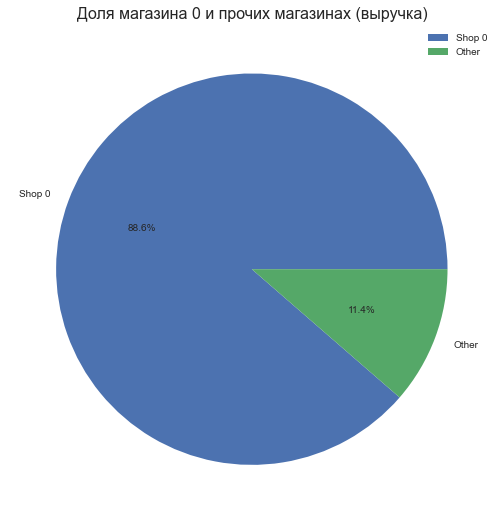

In [78]:
shops_by_categories['price'].plot(kind='pie', autopct='%1.1f%%')
plt.title('Доля магазина 0 и прочих магазинах (выручка)')
plt.ylabel('')
plt.legend();

88.6% выручки создается магазином 0. На основе очищенных данных о средних чеках выше рассчитаем, какова величина среднего чека в большом магазине и в мелких. 

In [79]:
checks_no_refund['shop_category'] = 'Other'
checks_no_refund.loc[checks_no_refund['shop_id'] == 'Shop 0', 'shop_category'] = 'Shop 0'

In [80]:
checks_by_shop = checks_no_refund.groupby('shop_category').agg({'price': 'mean', 
                                                'quantity': 'mean', 'date': 'count'}).reset_index()

In [81]:
checks_by_shop

,shop_category,price,quantity,date
0,Other,320.122047,13.107383,447
1,Shop 0,30.512619,2.420240,36215


Средняя величина и глубина чеков в Shop 0 меньше, однако является ли это различие значимым, мы сможем сказать только по результатам статистического теста. Для его подготовки разделим весь набор данных на две категории и проанализируем выбросы.

In [82]:
checks_0 = checks_no_refund[checks_no_refund['shop_category'] == 'Shop 0']
checks_0.describe()

,is_loyal,price,quantity
count,36215.000000,36215.000000,36215.000000
mean,0.027917,30.512619,2.420240
std,0.164736,112.505262,7.205068
min,0.000000,0.180000,1.000000
25%,0.000000,2.490000,1.000000
50%,0.000000,4.960000,1.000000
75%,0.000000,11.040000,1.000000
max,1.000000,3653.200000,242.000000


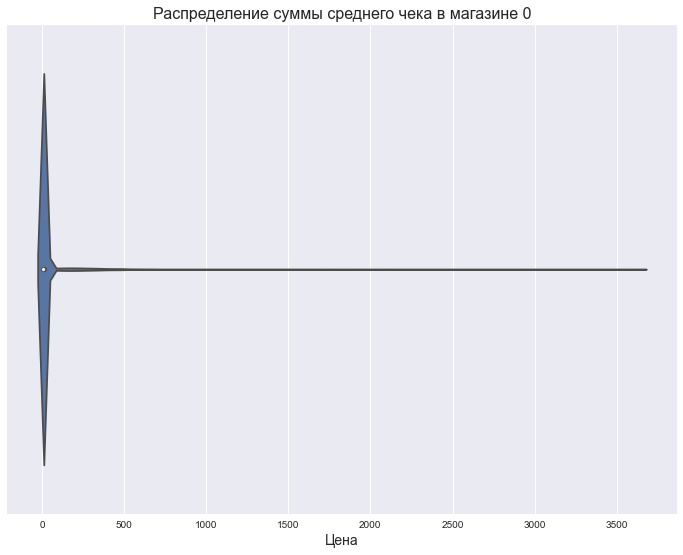

In [83]:
sns.violinplot(checks_0['price'])
plt.title('Распределение суммы среднего чека в магазине 0')
plt.xlabel('Цена');

Распределение имеет очень тяжелый хвост, что не дает возможности применять параметрические тесты. Отсеим те значения, которые отличаются от среднего больше, чем на три стандарных отклонения.

In [84]:
price_0 = checks_0[checks_0['price'] <= checks_0['price'].mean()+3*checks_0['price'].std()]['price']
price_0.describe()

count    35363.000000
mean        16.204292
std         45.356965
min          0.180000
25%          2.485000
50%          4.920000
75%         10.020000
max        367.415000
Name: price, dtype: float64

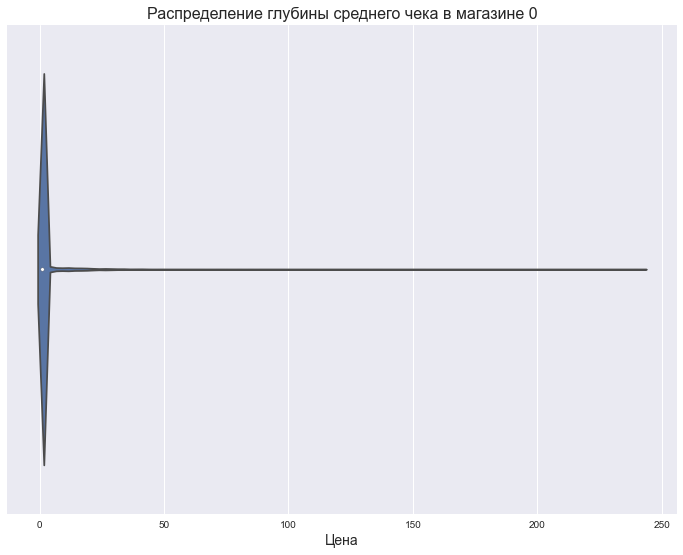

In [85]:
depth_0 = checks_0['quantity']
sns.violinplot(depth_0)
plt.title('Распределение глубины среднего чека в магазине 0')
plt.xlabel('Цена');

И здесь отсеим знаения по тому же принципу.

In [86]:
depth_0 = depth_0[depth_0 <= depth_0.mean()+3*depth_0.std()]
depth_0.describe()

count    35472.000000
mean         1.553873
std          2.638485
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         24.000000
Name: quantity, dtype: float64

In [87]:
checks_other = checks_no_refund[checks_no_refund['shop_category'] == 'Other']
price_other = checks_other['price']
checks_other.describe()

,is_loyal,price,quantity
count,447.000000,447.000000,447.000000
mean,0.008949,320.122047,13.107383
std,0.094278,411.909491,17.793210
min,0.000000,0.420000,1.000000
25%,0.000000,30.740000,1.000000
50%,0.000000,191.030000,8.000000
75%,0.000000,420.197500,16.500000
max,1.000000,3120.645000,148.000000


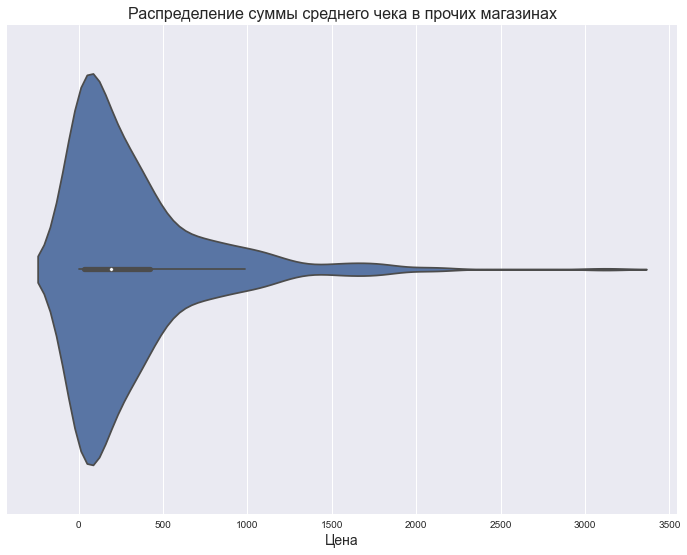

In [88]:
sns.violinplot(price_other)
plt.title('Распределение суммы среднего чека в прочих магазинах')
plt.xlabel('Цена');

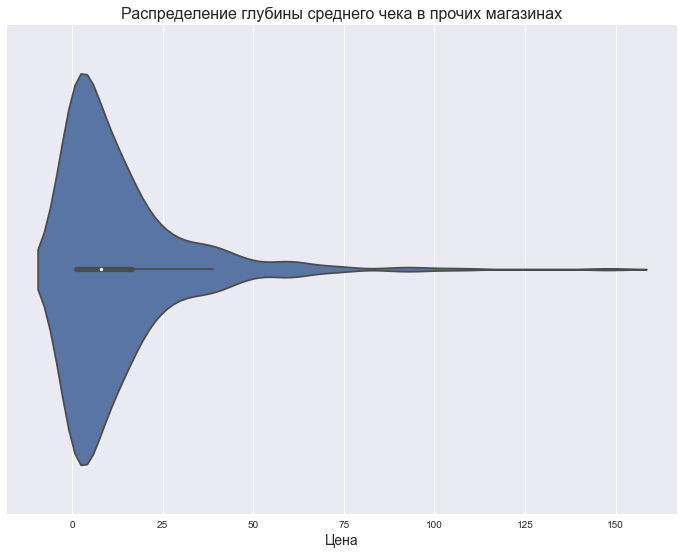

In [89]:
sns.violinplot(checks_other['quantity'])
plt.title('Распределение глубины среднего чека в прочих магазинах')
plt.xlabel('Цена');

In [90]:
depth_other = checks_other['quantity']

В прочих магазинов выбросов нет.

Еще два показателя, которые можно сравнить в разных магазинах, - это доля возврата и доля лояльных клиентов.

In [91]:
data['is_return'] = data.apply(lambda x: 1 if x['price'] < 0 else 0, axis=1)

In [92]:
loyal_and_return = data.groupby('shop_category').agg({'is_loyal': 'mean', 'is_return': 'mean'})
loyal_and_return

,is_loyal,is_return
shop_category,,
Other,0.015523,0.042810
Shop 0,0.237726,0.016276


### Анализ лояльных пользователей в магазине 0

Одно из характерных отличий магазина 0 - это большая доля участников программы лояльности, на которых приходится 24% покупок. Возможно, это влияет на выдающиеся показатели этого магазина. Посмотрим, как распределены продажи в этом магазине по трем категориям клиентов: участникам программы лояльности, известным покупателям, не участвующим в программе лояльности, и неизвестным покупателям.

In [93]:
checks_0.reset_index(inplace=True, level=[0, 1])

In [94]:
checks_0

,customer_id,purchase_dt,date,is_loyal,price,quantity,shop_id,shop_category
0,18426.0,2016-12-05 15:38:00,2016-12-05,0.0,183.59,5,Shop 0,Shop 0
1,18426.0,2016-12-13 10:41:00,2016-12-13,0.0,124.65,4,Shop 0,Shop 0
2,18426.0,2017-01-20 14:01:00,2017-01-20,0.0,60.12,2,Shop 0,Shop 0
3,18427.0,2016-12-01 12:48:00,2016-12-01,0.0,7.87,1,Shop 0,Shop 0
4,18427.0,2016-12-02 11:46:00,2016-12-02,0.0,8.29,1,Shop 0,Shop 0
...,...,...,...,...,...,...,...,...
36210,new03499,2017-01-05 11:30:00,2017-01-05,0.0,2.52,1,Shop 0,Shop 0
36211,new03499,2017-01-10 16:25:00,2017-01-10,0.0,2.50,1,Shop 0,Shop 0
36212,new03499,2017-01-17 17:44:00,2017-01-17,0.0,3.72,1,Shop 0,Shop 0
36213,new03499,2017-02-16 15:56:00,2017-02-16,0.0,13.16,1,Shop 0,Shop 0


In [95]:
checks_0['customer_id'] = checks_0['customer_id'].astype('str')
# я все понял про apply, больше так не буду
checks_0.loc[checks_0['customer_id'].str.contains('new'), 'is_loyal'] = 2

In [96]:
loyalty_analysis_0 = checks_0.groupby('is_loyal').agg({
    'customer_id': 'nunique',
    'purchase_dt': 'count',
    'price': ['sum', 'mean'],
    'quantity': 'mean'
})
loyalty_analysis_0.columns = ['customer_cnt', 'purchase_cnt', 'total_income', 'mean_check', 'mean_check_depth']
loyalty_analysis_0

,customer_cnt,purchase_cnt,total_income,mean_check,mean_check_depth
is_loyal,,,,,
0.0,882,1707,556486.325,326.002534,18.720562
1.0,529,1011,306713.635,303.376494,20.574679
2.0,3500,33497,241814.535,7.218991,1.041646


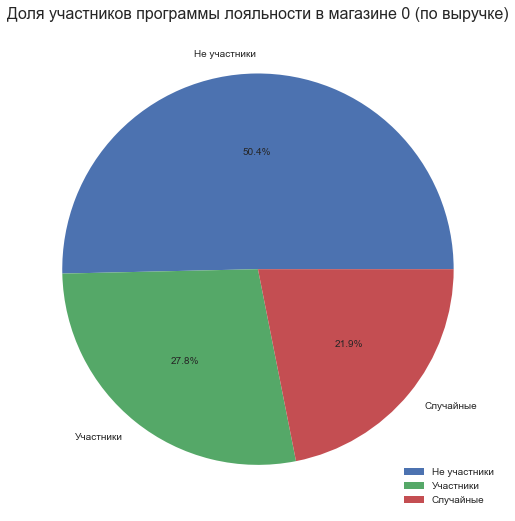

In [97]:
loyalty_analysis_0['total_income'].plot(kind='pie', autopct='%1.1f%%', labels=['Не участники', 'Участники', 'Случайные'])
plt.title('Доля участников программы лояльности в магазине 0 (по выручке)')
plt.ylabel('')
plt.legend();

Половина объема продаж приходится на известных клиентов, не пользующихся программой лояльности, доля выручки, которая приходится на пользователей программы лояльности - чуть больше четверти. Таким образом, 88% выручки создаются известными нам пользователями, а не "случайными" зашедшими (таковыми мы считаем тех, чей ID изначально не был известен), хотя на последних приходится абсолютно большая доля чеков (так что долю прочих чеков едва ли будет хорошо видно на графике). Их чеки состоят в среднем из одной позиции и имеют очень небольшую сумму (в 40 с лишним раз проигрывают другим категориям). Интересно, что самая большая сумма чека в среднем свойственна известным покупателям, не участвующим в программе лояльности, что возможно, объясняется скидками для участников программы лояльности, поскольку глубина чека у них в среднем больше.

#### Выводы
1. Как уже отмечалось выше, наши магазины не одинаковые - на один из них приходится абсолютно большая часть массива данных и выручки (почти 90%).
2. Поведение пользователей в самом большом магазине тоже отличное: средний чек здесь меньше и по сумме и по глубине, при этом здесь втрое меньшая доля возвратов и значительно большая доля покупок лояльных клиентов. Эти наблюдения мы проверим с помощью статистических тестов.

---
[Наверх](#contents)

---

## 5. Проведение статистических тестов <a id='test'></a>

В ходе статистических тестов мы будем сравнивать магазин 0 и все остальные магазины по следующих показателям:
- сумма среднего чека;
- глубина среднего чека;
- доля возврата;
- доля покупок лояльных клиентов.

Во всех случаях результаты тестов несколько портит диспропорция между выборками, однако они обе сравнительно большие, что отчасти компенсирует этот недостаток.

### Сумма среднего чека

Для сравнения сумму среднего чека применим t-тест для независимых выборок с разными дисперсиями. Нулевая гипотеза: статистически значимых различий между выборками нет, альтернативная гипотеза: в магазине 0 средний чек меньше. Критический уровень значимости - 0.05 (делится на два из-за того, что тест одностронний).

In [98]:
def one_sided_ttest(sample1, sample2, alpha=0.05):
    test = st.ttest_ind(sample1, sample2, equal_var=False)
    print(f'p-значение: {test[1]}')
    
    if test[1] < alpha / 2:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не удалось отвергнуть нулевую гипотезу')

In [99]:
one_sided_ttest(price_0, price_other)

p-значение: 4.3149525444029933e-44
Отвергаем нулевую гипотезу


Сумма среднего чека в магазине 0 меньше, и различие статистически значимо.

### Глубина среднего чека

Аналогично, применимя односторонний t-тест для независимых выборок с разными дисперсиями. Нулевая гипотеза: статистически значимых различий между выборками нет, альтернативная гипотеза: в магазине 0 глубина среднего чека меньше. Критический уровень значимости - 0.05.

In [100]:
one_sided_ttest(depth_0, depth_other)

p-значение: 5.109555416649207e-36
Отвергаем нулевую гипотезу


Глубина среднего чека в магазине 0 меньше, и различие статистически значимо.

### Доля возврата

Для сравнения долей возврата применим z-тест. Нулевая гипотеза: доли возврата в магазине 0 и в остальных значимо не отличаются, альтернативная гипотеза - доли отличаются. Критический уровень значимости - 0.05.

In [101]:
def z_test(col, alpha=0.05):
    total = np.array([len(data[data['shop_category'] == 'Shop 0']), 
                     len(data[data['shop_category'] == 'Other'])])
    share = np.array([len(data[(data['shop_category'] == 'Shop 0') & (data[col] == 1)]),
                     len(data[(data['shop_category'] == 'Other') & (data[col] == 1)])])
    
    # доли по группам, доля по комбинированной выборке, разница долей по группам
    p1 = share[0] / total[0]
    p2 = share[1] / total[1]
    p_comb = np.sum(share) / np.sum(total)
    diff = abs(p1 - p2)
    
    # z-статистика
    z_value = diff / np.sqrt(p_comb * (1 - p_comb) * (1 / total[0] + 1 / total[1]))
    
    # p-value
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(z_value)) * 2
    
    print(f'Результат z-теста:')
    print(f'\tz-статистика: {z_value}')
    print(f'\tp-значение: {p_value}')
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу\n\n')
    else:
        print('Не удалось отвергнуть нулевую гипотезу\n\n')

In [102]:
z_test('is_return')

Результат z-теста:
	z-статистика: 15.11135696189059
	p-значение: 0.0
Отвергаем нулевую гипотезу




Доля возвратов значимо отличается.

### Доля покупок лояльных клиентов

Для сравнения долей возврата применим z-тест. Нулевая гипотеза: доли покупок лояльных клиентов в магазине 0 и в остальных значимо не отличаются, альтернативная гипотеза - доли отличаются. Критический уровень значимости - 0.05.

In [103]:
z_test('is_loyal')

Результат z-теста:
	z-статистика: 40.3674775678589
	p-значение: 0.0
Отвергаем нулевую гипотезу




Доля покупок лояльных клиентов также значимо отличается.

---
[Наверх](#contents)

---

## 6. Классификация небольших магазинов <a id='clusters'></a>

Как видно, между магазином 0 и прочими есть существенные значчимые различия. Попробуем углубить классификацию магазинов - посмотрим, нет ли возможности разделить мелкие магазины на группы. Для этого соберем в один датафрейм все средние показатели для каждого магазина, а затем применим кластеризацию.

In [104]:
shops_compare_new = data.groupby('shop_id').agg({
    'customer_id': 'nunique',
    'purchase_dt': 'count',
    'price': 'mean',
    'quantity': 'mean',
    'item_id': 'nunique', 
    'is_return': 'mean',
    'is_loyal': 'mean'
}).sort_values('purchase_dt', ascending=False)

In [105]:
shops_compare_new.describe()

,customer_id,purchase_dt,price,quantity,item_id,is_return,is_loyal
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,176.333333,3175.633333,25.296711,11.538832,230.466667,0.018257,0.055504
std,906.551227,16241.956251,5.016526,5.116778,575.143564,0.024254,0.192362
min,1.000000,3.000000,12.167589,4.758887,3.000000,0.000000,0.000000
25%,1.250000,24.250000,23.608708,8.543090,24.250000,0.000000,0.000000
50%,3.500000,51.500000,25.822821,9.713805,45.000000,0.006257,0.000000
75%,9.500000,243.250000,26.949543,14.411596,178.750000,0.034779,0.000000
max,4975.000000,89149.000000,35.884444,26.222222,3128.000000,0.101469,1.000000


In [106]:
shops_compare_new

,customer_id,purchase_dt,price,quantity,item_id,is_return,is_loyal
shop_id,,,,,,,
Shop 0,4975,89149,12.167589,4.758887,3128,0.016276,0.237726
Shop 4,43,1498,20.675838,9.288385,660,0.101469,0.000000
Shop 1,37,1327,23.558843,10.123587,551,0.019593,0.000000
Shop 6,103,791,21.619817,7.624526,561,0.049305,0.000000
Shop 8,11,518,19.709073,7.054054,369,0.011583,0.119691
Shop 12,10,258,23.527287,10.930233,178,0.031008,0.000000
Shop 7,7,253,25.019368,11.679842,218,0.007905,0.000000
Shop 10,8,252,26.120397,8.932540,179,0.027778,0.000000
Shop 18,5,217,21.721682,7.391705,201,0.004608,0.000000


In [107]:
items_0 = data[data['shop_id'] == 'Shop 0']['item_id'].unique()
items_other = data[data['shop_id'] != 'Shop_0']['item_id'].unique()
unique_0 = np.setdiff1d(items_0, items_other)
unique_other = np.setdiff1d(items_other, items_0)
print(f'Уникальных товаров в магазине 0: {len(unique_0)}, отсутствуют в магазине 0: {len(unique_other)}')

Уникальных товаров в магазине 0: 0, отсутствуют в магазине 0: 11


Итак, мы дополнили таблицу сравнения магазинов данными о возвратах и об ассортименте. Самое большое число различных товаров продается в магазине 0, что, вероятно, также способствует большому числу продаж и покупателей. В целом, проданные товары разнообразнее там, где больше покупок (что вполне логично), однако это не абсолютное правило, например, магазин 1 имеет значительно больше продаж, чем магазин 6, но немного проигрывает по чилу разных товаров. При этом в магазине 0 нет товаров, которые нельзя было бы купить в других магазинах, более того, там нельзя купить 11 позиций, так что едва ли ассортимент является решающим фактором для радикально большего числа продаж в магазине 0.

Для более глубокой классификации магазинов попробуем применить кластеризацию. Поскольку значения признаков сильно отличаются по абсолютной величине, сначала скалируем их, затем построим дендрограмму признаков.

In [108]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(shops_compare_new)
linked = linkage(X_sc, method = 'ward')

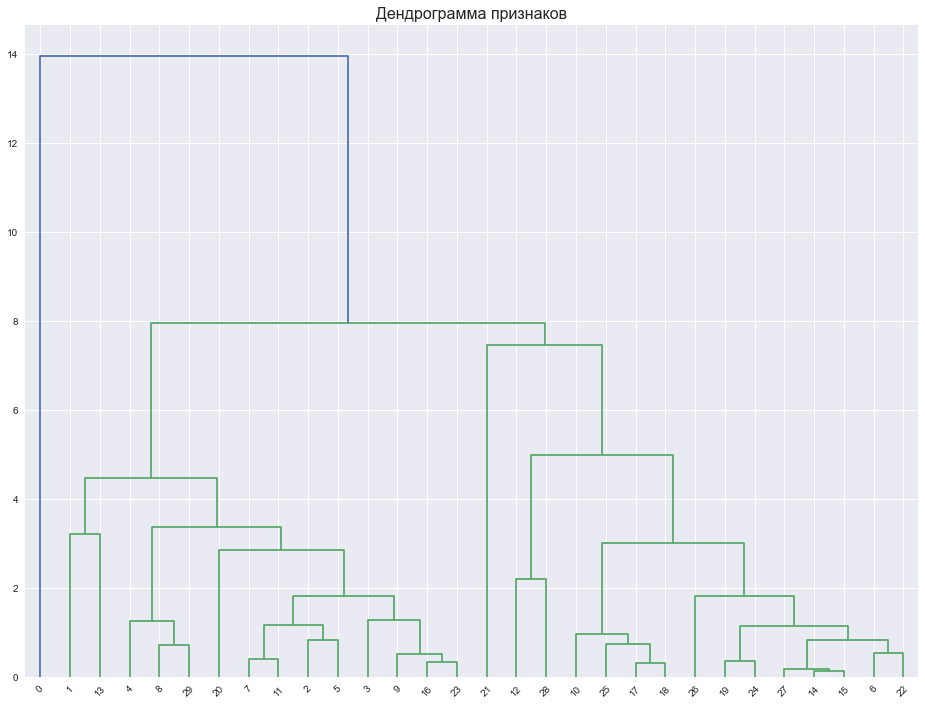

In [109]:
plt.figure(figsize=(16, 12))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма признаков')
plt.show()

Как и ожидалось, магазин 0 выделяется в один собственный кластер, поскольку он очень сильно отличается по всем параметрам. Однако, как видно, остальные магазины также могут быть разделены на две примерно равные по численности группы. Разделение на большее число кластеров кажется нецелесообразным, поскольку создаст группы из 1-2 небольших магазинов. Применим метод K средних с заданным числом кластеров, равным трем, а затем сравним получившиеся кластеры.

In [110]:
km = KMeans(n_clusters=3, random_state=42) 
labels = km.fit_predict(X_sc)
shops_compare_new['cluster'] = labels

In [111]:
for value in shops_compare_new.cluster.unique():
    slc = shops_compare_new[shops_compare_new['cluster'] == value]
    print(f'''
Кластер {value}: магазинов - {len(slc)}; покупок - {slc['purchase_dt'].sum()}    
    ''')


Кластер 2: магазинов - 1; покупок - 89149    
    

Кластер 0: магазинов - 13; покупок - 5263    
    

Кластер 1: магазинов - 16; покупок - 857    
    


In [112]:
shops_compare_new.pivot_table(index='cluster')

,customer_id,is_loyal,is_return,item_id,price,purchase_dt,quantity
cluster,,,,,,,
0,18.615385,0.009207,0.035874,235.307692,22.633885,404.846154,8.812166
1,4.562500,0.081731,0.004066,45.437500,28.280826,53.562500,14.177995
2,4975.000000,0.237726,0.016276,3128.000000,12.167589,89149.000000,4.758887


Итак, наши класны 0 и 1 объединяют 13 и 16 магазинов соответственно. В первый из них попали крупные магазины, за исключением магазина 0 - в среднем в таких магазинах 19 покупателей, очень низкая доля пользователей программы лояльности (>1%), также в этих магазинах самая высокая доля возврата - 3.5%. Они сильно прогрывают магазину 0 по число пукупок (404) и ассортименту (235 видов товара), но впятеро превосходят магазины из кластера 1. В кластере 1 магазины мелкие (или у нас мало данных о них) - здесь в среднем 5 покупателей, 8% из них пользуются программой лояльности. В этих магазинах самый высокий средний чек и наибольшая глубина чека.

---

[Наверх](#contents)

---

## 7. Общий вывод  <a id='conclusion'></a>

1. Проведенное исследование охватывает период с начала декабря 2016 до конца февраля 2017 года, за исключением воскресений и новогодных праздников - всего 68 дней. В среднем за день совершалось 1400 покупок, однако разброс значений весьма большой - от 253 до 3654, причем показатели сильно колеблются даже в соседние дни. Колебания после Нового года были меньше, но и покупок в день также было меньше.
2. Суточный пик продаж приходится на 14-15 часов, недельный - на вторник.
3. Больше 75% покупателей посещают магазины многократно: медианное число визитов - 10. Медианное число покупок на человека также равно 10. Больше 75% посещают единственный магазин, даже если совершают очень много покупок.
4. Абсолютное большинство чеков состоят из одной позиции, число чеков даже с тремя покупками очень мало, хотя есть и очень большие значения, вплоть до 244 позиций. Медианная сумма чека - 5, средняя - 34. Значения сильно разбросаны, при преобладании небольших покупок есть чеки в 3.6 тыс. у.е.
5. Среди магазинов сети один очень сильно отличается по всем показателям - на него приходится 80% массива данных и 88% суммарной выручки. Если сравнивать его со всем остальными магазинами, то можно заметить, что в нем меньшие средние чеки (по сумме и по глубине), меньше доля возврата и больше процент лояльных покупателей, а также очень много неидентифированных пользователей. При этом в нем нет товаров, которые нельзя купить в других магазинах и даже кое-чего не хватает, поэтому едва ли его значительные продажи обсуловлены ассортиментом, разве что покупателям нравится возможность купить все в одном месте.
6. Остальные магазины можно разделить на два кластера. В первый входят относительно крупные магазины, в среднем в таких магазинах 19 покупателей, очень низкая доля пользователей программы лояльности (>1%), а также самая высокая доля возврата - 3.5%. Они сильно прогрывают магазину 0 по число пукупок (404) и ассортименту (235 видов товара), но впятеро превосходят магазины из последнего кластера. В нем магазины мелкие - в среднем 5 покупателей, 8% из них пользуются программой лояльности, однако самые высокие сумма и глубина среднего чека.
7. Половина объема продаж в магазине 0 приходится на известных клиентов, не пользующихся программой лояльности, доля выручки, которая приходится на пользователей программы лояльности - 28%. Чеки "случайных" клиентов очень многочисленны, но состоят в среднем из одной позиции и имеют очень небольшую сумму (в 40 с лишним раз проигрывают другим категориям). Самая большая сумма чека в среднем свойственна известным покупателям, не участвующим в программе лояльности, что возможно, объясняется скидками для участников программы лояльности, поскольку глубина чека у них в среднем больше.

---
[Наверх](#contents)